In [1]:
import cv2
import os
import seaborn as sns
import numpy as np
import shutil
from lxml import etree as ET
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from bidi.algorithm import get_display
import arabic_reshaper
from wordcloud import WordCloud
import pandas as pd

In [2]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [3]:
def coordinates(cnt):
    coords= str(cnt[0])+','+str(cnt[1])+' '+str(cnt[0]+cnt[2])+','+str(cnt[1])+' '+str(cnt[0]+cnt[2])+','+str(cnt[1]+cnt[3])+' '+str(cnt[0])+','+str(cnt[1]+cnt[3])
    return coords

In [4]:
def one_box(rectList):
    arr = []
    for rect in rectList:
        arr.append((rect[0],rect[1]))
        arr.append((rect[0]+rect[2],rect[1]+rect[3]))
    (x,y,w,h) = cv2.boundingRect(np.asarray(arr))
    return x,y,w,h

In [5]:
def one_label(labelList):
    line_label=''
    for label in labelList:
        line_label=line_label+' '+label
    return line_label

In [6]:
def reduce_height(h):
    if h <= 35:
        reduced_h = 5
    else:
        reduced_h = h - 30
    return reduced_h

In [7]:
def words_from_xml(xml_file_path, image_name):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    word_bboxes = []
    word_labels = []
    for page in root.findall('.//image[@src="%s"]'%image_name):
        print ('Started to gather the words on '+ image_name)
        for zone in page.iter('zone'):           
            c = 0
            for point in zone.iter('point'):
                if c == 0:
                    x0 = point.attrib.get('x')
                    y0 = point.attrib.get('y')
                if c == 1:
                    x1 = point.attrib.get('x')
                    y1 = point.attrib.get('y')
                if c == 2:
                    x2 = point.attrib.get('x')
                    y2 = point.attrib.get('y')
                if c == 3:
                    x3 = point.attrib.get('x')
                    y3 = point.attrib.get('y')
                c = c+1
            x = int(x0)
            y = int(y0)
            w = int(x1)-int(x0)
            h = int(y2)-int(y1)          
            word_bbox = [x, y, w, h]
            id=int(zone.attrib.get('id'))
            word_label=None
            for segment in root.iter('segment'):
                tid=int(segment.attrib.get('id'))
                if tid==id:
                    word_label= segment[1].text
            if word_label is None:
                word_label='mislabel'
                print ('there is a mismatch label on zone id: ' + str(id))
            else:
                word_bboxes.append(word_bbox)
                word_labels.append(word_label)
    print('Gathered '+ str(len(word_labels)) + ' words on ' +image_name)
    return word_bboxes, word_labels

In [8]:
def lines_from_words(word_bboxes, word_labels):
    line_bboxes = []
    line_labels = []
    sorted_word_bboxes = []
    sorted_word_labels = []
    # Sort by y coordinate
    word_bboxes, word_labels = zip(*sorted(zip(word_bboxes, word_labels), key=lambda p: p[0][1]))
    word_bboxes = list(word_bboxes)
    word_labels = list(word_labels)
    # Bottom of the first rectangle is the baseline
    reduced_h = reduce_height(word_bboxes[0][3])
    baseline = word_bboxes[0][1] + reduced_h - 1
    end_idx = 0
    for i in range(len(word_bboxes)):
        # Continue iterating until the box whose y coordinate is below the current baseline
        if word_bboxes[i][1] > baseline:
            # Sort the boxes whose y coordinates are above the current baseline, by their x coordinate, in descending order
            word_bboxes[end_idx:i], word_labels[end_idx:i] = zip(*sorted(zip(word_bboxes[end_idx:i], word_labels[end_idx:i]), reverse=True, key=lambda p: p[0][0]))

            if len(word_bboxes[end_idx:i])>0:
                line_bbox = one_box(word_bboxes[end_idx:i])
                line_bboxes.append(line_bbox)
                line_label = one_label(word_labels[end_idx:i])
                line_labels.append(line_label)
                sorted_word_bboxes.append(word_bboxes[end_idx:i])
                sorted_word_labels.append(word_labels[end_idx:i])

            end_idx = i
        # Update the baseline. 
        # New baseline is the bottom of the box whose y coordinate is below the current baseline
        reduced_h = reduce_height(word_bboxes[i][3])
        baseline = max(word_bboxes[i][1] + reduced_h - 1, baseline)

    # Sort the word bboxes at the final line
    word_bboxes[end_idx:i], word_labels[end_idx:i] = zip(*sorted(zip(word_bboxes[end_idx:i], word_labels[end_idx:i]), reverse=True, key=lambda p: p[0][0]))
    if len(word_bboxes[end_idx:i])>0:
        line_bbox = one_box(word_bboxes[end_idx:i])
        line_bboxes.append(line_bbox)
        line_label = one_label(word_labels[end_idx:i])
        line_labels.append(line_label)
        sorted_word_bboxes.append(word_bboxes[end_idx:i])
        sorted_word_labels.append(word_labels[end_idx:i])
        
        return sorted_word_bboxes, sorted_word_labels, line_bboxes, line_labels

In [9]:
def generate_pagexml(xml_folder_path, image_file_path, sorted_word_bboxes, sorted_word_labels, line_bboxes, line_labels):
    xmlns = "http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15"
    xsi ="http://www.w3.org/2001/XMLSchema-instance"
    schemaLocation = "http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15 http://schema.primaresearch.org/PAGE/gts/pagecontent/2019-07-15/pagecontent.xsd"

    PcGts = ET.Element("{" + xmlns + "}PcGts",
                           attrib={"{" + xsi + "}schemaLocation" : schemaLocation}, 
                            nsmap={'xsi': xsi, None: xmlns})
    PcGts.set("pcGtsId","pc-aletheiaexamplepage")
    Metadata = ET.SubElement(PcGts, 'Metadata')
    Creator = ET.SubElement(Metadata, 'Creator')
    Creator.text='PRImA Research Lab'
    Metadata.append(Creator)
    Created = ET.SubElement(Metadata, 'Created')
    Created.text='2015-07-17T15:27:13' 
    Metadata.append(Created)
    LastChange = ET.SubElement(Metadata, 'LastChange')
    LastChange.text='2017-07-14T10:03:33' 
    Metadata.append(LastChange)
    Comments = ET.SubElement(Metadata, 'Comments')
    Comments.text='Example Page' 
    Metadata.append(Comments)
    PcGts.append(Metadata)

    img = cv2.imread(image_file_path)

    rows,cols,_=img.shape
    Page=ET.SubElement(PcGts,'Page')
    Page.set('imageFilename',image_file_path) 
    Page.set('imageWidth',str(cols))
    Page.set('imageHeight',str(rows))
    
    textregionid=0
    coords= '1,1 '+str(cols-2)+',1 '+str(cols-2)+','+str(rows-2)+' 1,'+str(rows-2)
    TextRegion = ET.SubElement(Page, 'TextRegion')   
    TextRegion.set('id','r'+str(textregionid))
    TextRegion.set('type','paragraph')
    Page.append(TextRegion)
    Coords = ET.SubElement(TextRegion, 'Coords')        
    Coords.set('points',coords)
    TextRegion.append(Coords)

    textlineid = 0
    wordid = 0
    for line_bbox in line_bboxes:
        tcoords = coordinates(line_bbox)
        TextLine = ET.SubElement(TextRegion, 'TextLine')   
        TextLine.set('id','l'+str(textlineid))
        TextRegion.append(TextLine)

        Coords = ET.SubElement(TextLine, 'Coords')        
        Coords.set('points',tcoords)
        TextLine.append(Coords)

        textlinewordid = 0
        for word_bbox in sorted_word_bboxes[textlineid]:
            wcoords = coordinates(word_bbox)
            Word = ET.SubElement(TextLine, 'Word')
            Word.set('id','w'+str(wordid))
            Coords = ET.SubElement(Word, 'Coords')        
            Coords.set('points',wcoords)
            TextEquiv = ET.SubElement(Word, 'TextEquiv')
            UnicodeTextEquiv = ET.SubElement(TextEquiv, 'Unicode')
            UnicodeTextEquiv.text = sorted_word_labels[textlineid][textlinewordid]
            TextEquiv.append(UnicodeTextEquiv)
            Word.append(TextEquiv)
            TextLine.append(Word)
            textlinewordid = textlinewordid+1
            wordid = wordid + 1

        TextEquiv = ET.SubElement(TextLine, 'TextEquiv')
        UnicodeTextEquiv = ET.SubElement(TextEquiv, 'Unicode')
        UnicodeTextEquiv.text = line_labels[textlineid]
        TextEquiv.append(UnicodeTextEquiv)
        TextLine.append(TextEquiv)

        textlineid = textlineid + 1
    
    
    mydata = ET.tostring(PcGts,pretty_print=True, encoding='utf-8', xml_declaration=True)    
    image_name = image_file_path.split('/')[1][:-4]
    myfile = open(xml_folder_path+'/'+image_name+'.xml', "wb")  
    myfile.write(mydata) 
    myfile.close()

In [10]:
def save_wordcloud(total_sorted_word_labels, image_folder_path):
    reshaped_text = arabic_reshaper.reshape(' '.join(flatten(flatten(total_sorted_word_labels))))
    bidi_text = get_display(reshaped_text)
    wordcloud = WordCloud(font_path='arial.ttf',background_color='white', mode='RGB',width=2000,height=1000).generate(bidi_text)
    wordcloud.to_file("{}_wordcloud.png".format(image_folder_path))
    return

In [11]:
def stats(image_folder_path, total_sorted_word_labels):
    #In total_line_labels every word is accompanied with a space. 
    #Consider total_sorted_word_labels for counting
    print ('STATISTICS OF THE BOOK ' + image_folder_path)

    number_of_pages = 0
    number_of_lines = 0
    number_of_words = 0
    avg_number_of_words_per_page = 0
    avg_number_of_words_per_line = 0
    avg_number_of_words_classes = 0

    word_dist_per_class = []
    word_dist_per_page = []
    word_dist_per_line = []
    line_dist_per_page = []

    classes, word_dist_per_class = np.unique(flatten(flatten(total_sorted_word_labels)), return_counts=True)
    number_of_classes = len(classes)

    for page in total_sorted_word_labels:
        number_of_pages += 1
        line_dist_per_page.extend([len(page)])
        word_dist_per_page.extend([len(flatten(page))])
        for line in page:
            number_of_lines += 1
            word_dist_per_line.extend([len(line)])
            for word in line:
                number_of_words += 1


    print('number_of_pages: ',number_of_pages)
    print('number_of_lines: ',number_of_lines)
    print('number_of_words: ',number_of_words)
    print('number_of_classes: ',number_of_classes)
    avg_number_of_words_per_page = number_of_words/number_of_pages
    avg_number_of_lines_per_page = number_of_lines/number_of_pages
    avg_number_of_words_per_line = number_of_words/number_of_lines
    avg_number_of_words_classes = number_of_words/number_of_classes
    print('avg_number_of_words_per_page: ',avg_number_of_words_per_page)
    print('avg_number_of_lines_per_page: ',avg_number_of_lines_per_page)
    print('avg_number_of_words_per_line: ',avg_number_of_words_per_line)
    print('avg_number_of_words_classes: ',avg_number_of_words_classes)
    
    f = open("vml_word_line_stats.txt", "a")
    f.write('\n\n STATISTICS OF THE BOOK ' + image_folder_path + '\n' )
    f.write('number_of_pages: ' + str(number_of_pages) + '\n')
    f.write('number_of_lines: ' + str(number_of_lines) + '\n')
    f.write('number_of_words: ' + str(number_of_words) + '\n')
    f.write('number_of_classes: ' + str(number_of_classes) + '\n')
    f.write('avg_number_of_words_per_page: ' + str(avg_number_of_words_per_page) + '\n')
    f.write('avg_number_of_lines_per_page: ' + str(avg_number_of_lines_per_page) + '\n')
    f.write('avg_number_of_words_per_line: ' + str(avg_number_of_words_per_line) + '\n')
    f.write('avg_number_of_words_classes: ' + str(avg_number_of_words_classes) + '\n')
    f.close()
    
    #Form the dataframes
    book_name_list_for_pages = [image_folder_path] * number_of_pages

    word_dist_per_page_df = pd.DataFrame({'book_name': book_name_list_for_pages})
    word_dist_per_page_df['number_of_words'] = word_dist_per_page
    
    line_dist_per_page_df = pd.DataFrame({'book_name': book_name_list_for_pages})
    line_dist_per_page_df['number_of_lines'] = line_dist_per_page
    
    book_name_list_for_lines = [image_folder_path] * number_of_lines
    
    word_dist_per_line_df = pd.DataFrame({'book_name': book_name_list_for_lines})
    word_dist_per_line_df['number_of_words'] = word_dist_per_line
    
    book_name_list_for_classes = [image_folder_path] * number_of_classes
    
    word_dist_per_class_df = pd.DataFrame({'book_name': book_name_list_for_classes})
    word_dist_per_class_df['number_of_words'] = word_dist_per_class
    
    return word_dist_per_page_df, word_dist_per_line_df, line_dist_per_page_df, word_dist_per_class_df


In [12]:
image_folder_paths = ['3249138', '3157556', '3158466', '3426930', '3368132']
all_books_word_dist_per_page_df = pd.DataFrame(columns=['book_name','number_of_words'])
all_books_word_dist_per_line_df = pd.DataFrame(columns=['book_name','number_of_words'])
all_books_line_dist_per_page_df = pd.DataFrame(columns=['book_name','number_of_lines'])
all_books_word_dist_per_class_df = pd.DataFrame(columns=['book_name','number_of_words'])
all_books_classes_per_book_df = pd.DataFrame(columns=['book_name','number_of_words'])
if os.path.exists("vml_word_line_stats.txt"):
    os.remove("vml_word_line_stats.txt")
for image_folder_path in image_folder_paths:
    print('Started to process the book ', image_folder_path)
    xml_file_path = image_folder_path + '/' + image_folder_path + '_word_annotations.xml'
    xml_folder_path = image_folder_path + '_word_and_line_annotations'
    if os.path.isdir(xml_folder_path):
        shutil.rmtree(xml_folder_path)
    os.mkdir(xml_folder_path)
    total_sorted_word_labels = []
    total_line_labels = []
    c=0
    for image_name_and_ext in os.listdir(image_folder_path):
        if image_name_and_ext[-3:] == 'png':
            print(image_name_and_ext)
            image_name = image_name_and_ext[:-4]

            word_bboxes, word_labels = words_from_xml(xml_file_path, image_name)
            print ('Started to sort the words on page '+ image_name)
            sorted_word_bboxes, sorted_word_labels, line_bboxes, line_labels = lines_from_words(word_bboxes, word_labels)

            #Accumulate for total statistics
            total_sorted_word_labels.append(sorted_word_labels)
            total_line_labels.append(line_labels)

            print ('Started to generate pagexml for page '+ image_name)
            image_file_path = image_folder_path + '/' + image_name_and_ext
            generate_pagexml(xml_folder_path, image_file_path, sorted_word_bboxes, sorted_word_labels, line_bboxes, line_labels)

            c=c+1
            if c ==2:
                break

    word_dist_per_page_df, word_dist_per_line_df, line_dist_per_page_df, word_dist_per_class_df = stats(image_folder_path, total_sorted_word_labels)
    all_books_word_dist_per_page_df = pd.concat([all_books_word_dist_per_page_df, word_dist_per_page_df], axis=0)
    all_books_word_dist_per_line_df = pd.concat([all_books_word_dist_per_line_df, word_dist_per_line_df], axis=0)
    all_books_line_dist_per_page_df = pd.concat([all_books_line_dist_per_page_df, line_dist_per_page_df], axis=0)
    all_books_word_dist_per_class_df = pd.concat([all_books_word_dist_per_class_df, word_dist_per_class_df], axis=0)
    
    save_wordcloud(total_sorted_word_labels, image_folder_path)
    
print ('\n\n All the books have been processed.')   

Started to process the book  3249138
0007-1.png
Started to gather the words on 0007-1
Gathered 290 words on 0007-1
Started to sort the words on page 0007-1
Started to generate pagexml for page 0007-1
0007-2.png
Started to gather the words on 0007-2
there is a mismatch label on zone id: 145632
Gathered 262 words on 0007-2
Started to sort the words on page 0007-2
Started to generate pagexml for page 0007-2
STATISTICS OF THE BOOK 3249138
number_of_pages:  2
number_of_lines:  29
number_of_words:  550
number_of_classes:  207
avg_number_of_words_per_page:  275.0
avg_number_of_lines_per_page:  14.5
avg_number_of_words_per_line:  18.96551724137931
avg_number_of_words_classes:  2.657004830917874
Started to process the book  3157556
0003-1.png
Started to gather the words on 0003-1
there is a mismatch label on zone id: 119523
Gathered 55 words on 0003-1
Started to sort the words on page 0003-1
Started to generate pagexml for page 0003-1
0003-2.png
Started to gather the words on 0003-2
there is a 

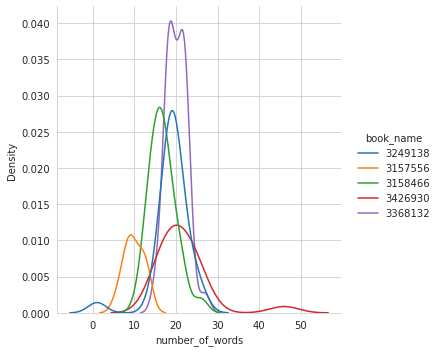

In [13]:
sns.set_style('whitegrid')
all_books_word_dist_per_line_df["number_of_words"] = all_books_word_dist_per_line_df["number_of_words"].astype(int)
snsplot=sns.displot(data=all_books_word_dist_per_line_df, x="number_of_words", hue="book_name", kind="kde")
snsplot.savefig('all_books_word_dist_per_line.png', dpi=300)

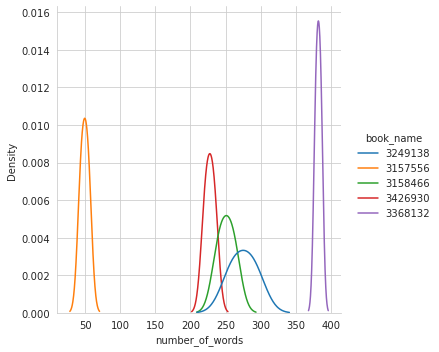

In [14]:
sns.set_style('whitegrid')
all_books_word_dist_per_page_df["number_of_words"] = all_books_word_dist_per_page_df["number_of_words"].astype(int)
sns.displot(data=all_books_word_dist_per_page_df, x="number_of_words", hue="book_name", kind="kde")
snsplot.savefig('all_books_word_dist_per_page.png', dpi=300)

/home/berat/.conda/envs/mafcn/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/berat/.conda/envs/mafcn/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/berat/.conda/envs/mafcn/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


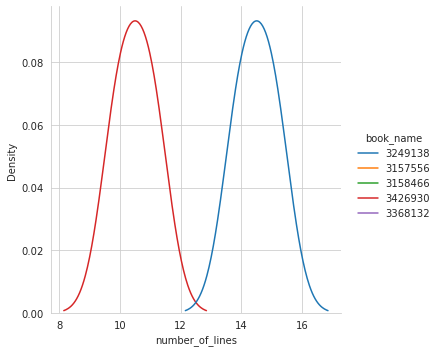

In [15]:
sns.set_style('whitegrid')
all_books_line_dist_per_page_df["number_of_lines"] = all_books_line_dist_per_page_df["number_of_lines"].astype(int)
sns.displot(data=all_books_line_dist_per_page_df, x="number_of_lines", hue="book_name", kind="kde")
snsplot.savefig('all_books_line_dist_per_page.png', dpi=300)

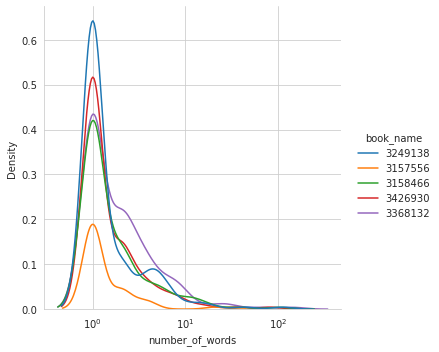

In [16]:
sns.set_style('whitegrid')
all_books_word_dist_per_class_df["number_of_words"] = all_books_word_dist_per_class_df["number_of_words"].astype(int)
sns.displot(data=all_books_word_dist_per_class_df, x="number_of_words", hue="book_name", kind="kde", log_scale=True)
snsplot.savefig('all_books_word_dist_per_class.png', dpi=300)